In [1]:
import pylab
import matplotlib as mpl
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from scipy.interpolate import UnivariateSpline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

from scipy.stats import friedmanchisquare

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h3> This loads in the data </h3>

In [2]:
Ani=pd.read_excel('/Users/attiladobi/Documents/Ani/sept_oct2013.xlsx',skiprows=0)
#Ani=pd.read_excel('data/sept_oct2013.xlsx',skiprows=0)
Time=array(Ani['Time'].T,dtype='datetime64')
Ani['Hour']=pd.DatetimeIndex(Ani['Time']).hour #sort by hours of the day
Ani['Day']=pd.DatetimeIndex(Ani['Time']).day #sort by hours of the day
Ani['Month']=pd.DatetimeIndex(Ani['Time']).month #sort by hours of the day
Ani['datenum']=Time.astype(int64)// 10**9 #sort by hours of the day

<h1> List the available keys </h1>

In [3]:
Ani.keys()

Index([   u'Time',     u'TS2',     u'HS2',     u'DS2',    u'TSh6',    u'HSh6',
          u'DSh6',    u'TSh7',    u'HSh7',    u'DSh7',    u'TS10',    u'HS10',
          u'DS10',   u'TSh16',   u'HSh16',   u'DSh16',   u'TSh17',    u'Sh17',
         u'DSh17',    u'TS19',    u'HS19',    u'DS19',   u'TSh19',   u'HSh19',
         u'DSh19',    u'TS27',    u'HS27',    u'DS27',    u'TS29',    u'HS29',
          u'DS29',    u'TS32',    u'HS32',    u'DS32',   u'TSh33',   u'HSh33',
         u'DSh33',    u'TS34',    u'HS34',    u'DS34',   u'TSh35',   u'HSh35',
         u'DSh35',    u'TS37',    u'HS37',    u'DS37',   u'TSh42',   u'HSh42',
         u'DSh42',     u'TK5',     u'HK5',     u'DK5',     u'TK8',     u'HK8',
           u'DK8',    u'Hour',     u'Day',   u'Month', u'datenum'],
      dtype='object')

In [42]:
a=np.arange(0,24)
print(a)
a[0:3]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


array([0, 1, 2])

<h1> Pull out temperature data sorted by hour for plotting </h1>

In [70]:
vals_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='TK') | (key[0:2]=='TS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_hour.append(vals)
#vals_hour
savetxt('data/Ani_temp.txt',vals_hour)

<h1> Convert list to array and select on back sun sensors, then plot :p </h1>

In [71]:
array_hour=np.array(vals_hour)

In [73]:
array_hour.shape

(24, 18)

In [81]:
array_hour[:,4] #list all hours for 5th temperature sensor

array([  9.50064103,   8.52115385,   7.71538462,   6.83846154,
         6.21730769,   5.93966713,   5.41136364,   6.04772727,
        10.84393939,  14.36515152,  19.12564103,  23.56089744,
        26.73477673,  29.36388889,  30.56597222,  30.60972222,
        29.74652778,  28.29027778,  27.05277778,  23.18611111,
        18.86730769,  16.14679487,  13.68910256,  11.29102564])

In [97]:
TS_back_ave=mean(array_hour[:,[-1,-4,-7]],1) #take the mean over the three sensors
TS_front_ave=mean(array_hour[:,[4,6,8,9,10]],1) #take the mean over the three sensors

(0, 23)

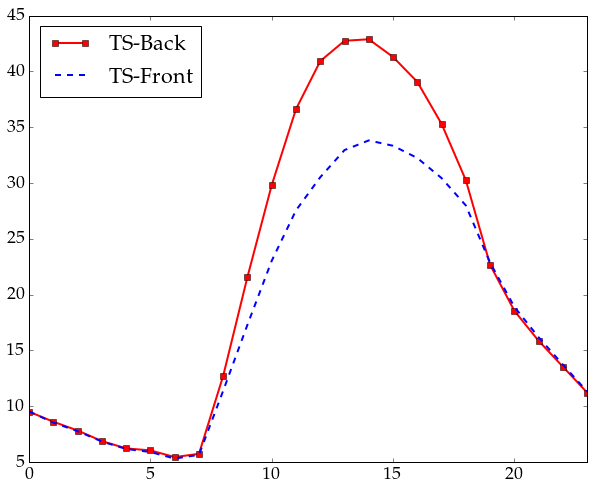

In [102]:
hour=np.arange(0,24) #makes the x axis, we use 0-23 for time on the plot.
plt.plot(hour,TS_back_ave,'s-r',linewidth=2) #TS2, TS10, TS19. We reversed the order. -1 is index TS2
plt.plot(hour,TS_front_ave,'--b') #front sensor
plt.legend(('TS-Back','TS-Front'),loc='upper left') #add lables and location on the plot
xlim(0,23) #sets the x-limits on the plot

<h1> Pull out humidity data sorted by hour for plotting </h1>

In [7]:
vals_hum_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='HK') | (key[0:2]=='HS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_hum_hour.append(vals)
savetxt('data/Ani_hum.txt',vals_hum_hour)

<h1> Get dewpoint data by the hour </h1>

In [8]:
vals_dew_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='DK') | (key[0:2]=='DS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_dew_hour.append(vals)
savetxt('data/Ani_dew.txt',vals_dew_hour)

<h1> Plot the means of Sun-back, sun-front, shade and control vs. time of day.
First define function get_ave_values </h1>

In [4]:
def get_ave_values(str1='T'):
    shade_ave_all=[]
    sun_ave_front=[]
    sun_ave_back=[]
    con_ave_all=[]
    hours=np.arange(0,24)
    for hour in hours:
        means_sun_back=[]
        means_sun_front=[]
        means_shade=[]
        means_con=[]
        for key in Ani.keys():
            if (key[0:3]==str1+'Sh'):
                means_shade.append(Ani[key].loc[Ani['Hour']==hour].mean())
                #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
            elif ((key[0:3]==str1+'S2') | (key[0:4]==str1+'S10') | (key[0:4]==str1+'S19') ):
                means_sun_back.append(Ani[key].loc[Ani['Hour']==hour].mean())
            elif (key[0:2]==str1+'S'):
                means_sun_front.append(Ani[key].loc[Ani['Hour']==hour].mean())
            elif (key[0:2]==str1+'K'):
                means_con.append(Ani[key].loc[Ani['Hour']==hour].mean())
        shade_ave_all.append(mean(means_shade))
        sun_ave_back.append(mean(means_sun_back))
        sun_ave_front.append(mean(means_sun_front))
        con_ave_all.append(mean(means_con))
    return np.array(sun_ave_back), np.array(sun_ave_front), np.array(shade_ave_all), np.array(con_ave_all)

<h1> Plot the sun data broken down by hour and type </h1>

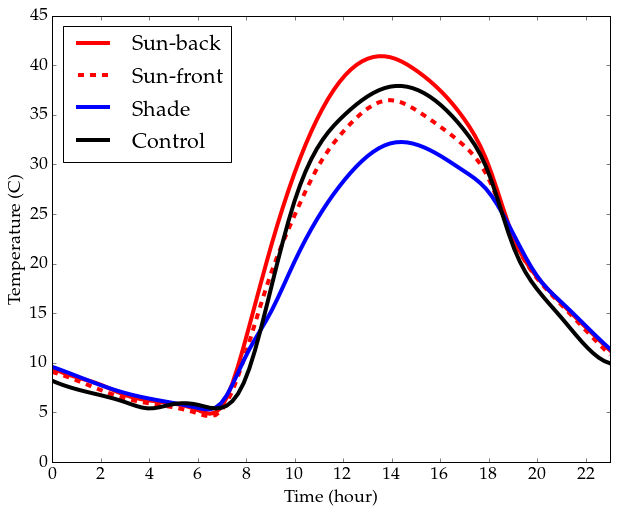

In [5]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('T')
hours=np.arange(0,24) #x data for y values

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

######### plot without spine  #############
#plot(hours,sun_ave_back,'-r',linewidth=4)
#plot(hours,sun_ave_front,'--r',linewidth=4)
#plot(hours,shade_ave_all,'-b',linewidth=4)
#plot(hours,con_ave_all,'-k',linewidth=4)

ylabel('Temperature (C)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper left')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/temp_means.png')

<h1> Friedman test... need to read up on this. Scipy Friedman test</h1>

In [ ]:
#needs 3 arrays as inputs
friedmanchisquare(np.array(sun_ave_back),np.array(sun_ave_front),np.array(shade_ave_all))

<h1> Humidity </h1>

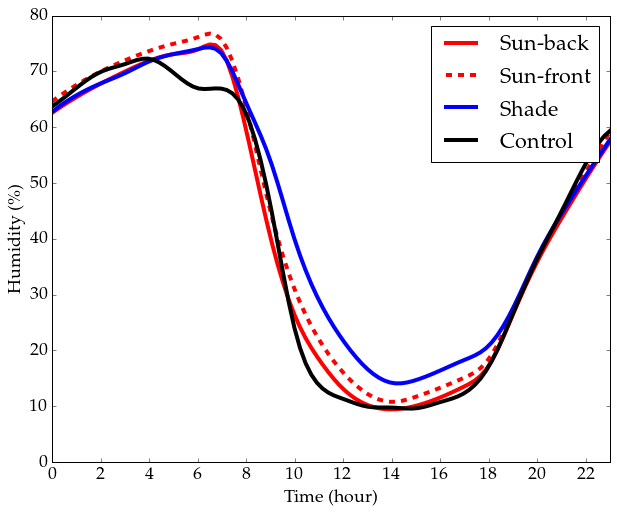

In [121]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('H')

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

ylabel('Humidity (\%)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper right')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/hum_means.png')

<h1> Dew Point </h1>

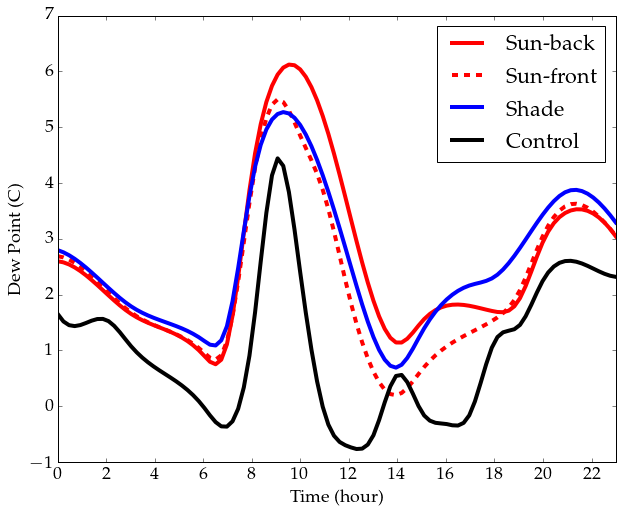

In [123]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('D')

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

ylabel('Dew Point (C)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper right')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/dew_means.png')

<h1> Build data frame to plot correleations </h1>

In [6]:
hours=np.arange(0,24)
Ani_hourly = {} #create a blank dictionary

for str1 in ['T','H','D']:
    sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values(str1)
    Ani_hourly.update({str1+'Sb':sun_ave_back,str1+'Sf':sun_ave_front,str1+'Sh':shade_ave_all,str1+'C':con_ave_all})
#build Pandas dataframe from dictionary
Ani_panda = pd.DataFrame(Ani_hourly,index=hours)

In [7]:
Ani_panda

,DC,DSb,DSf,DSh,HC,HSb,HSf,HSh,TC,TSb,TSf,TSh
0,1.652986,2.609014,2.699683,2.805449,63.716319,62.541241,64.597302,62.734066,8.211111,9.497125,9.110595,9.621955
1,1.453611,2.354597,2.429675,2.505609,67.006944,65.450844,67.637857,65.698718,7.303472,8.556537,8.153968,8.618590
2,1.579792,2.099293,2.166571,2.221859,69.952778,67.727672,69.904444,67.847985,6.804514,7.782054,7.388333,7.844872
3,1.047222,1.611739,1.613595,1.752115,71.231597,69.905020,71.900079,69.661813,6.010417,6.809191,6.405675,6.967788
4,0.663333,1.405820,1.411143,1.531042,72.332639,72.075105,73.844921,71.778388,5.405208,6.151224,5.809484,6.299119
5,0.511302,1.340545,1.380738,1.525399,69.778840,72.990435,74.816296,73.143055,5.833895,5.919368,5.615743,6.032854
6,-0.049583,0.908895,0.941556,1.114905,66.975000,73.874715,76.108333,73.895346,5.808333,5.299535,4.919907,5.466098
7,-0.391250,1.080156,1.111935,1.457973,66.908333,73.734485,75.710046,73.281710,5.439583,5.512934,5.172500,5.950189
8,1.193750,4.236644,4.013787,4.065833,62.368750,59.456806,63.543796,64.222403,8.543750,12.606917,11.105046,10.810985
9,4.507917,5.956449,5.507944,5.185159,46.239583,40.355682,45.026944,54.169180,17.260417,21.471717,18.863102,14.972102


<h1> Plot all the average Humidity vs. average Temperature </h1>

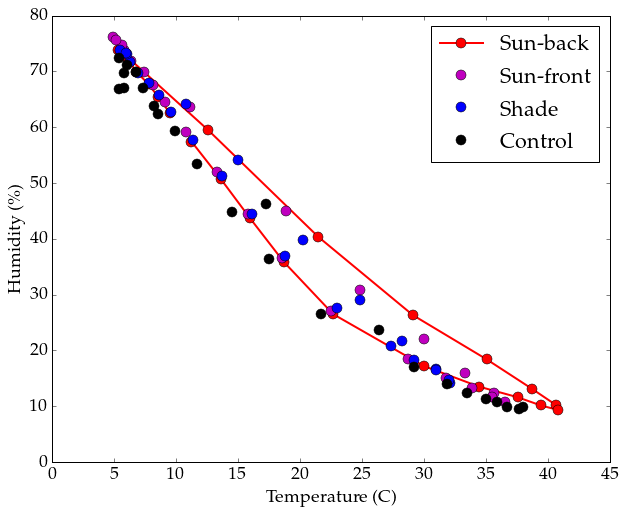

In [8]:
plt.plot(Ani_panda.TSb,Ani_panda.HSb,'-ro',markersize=10)
plt.plot(Ani_panda.TSf,Ani_panda.HSf,'mo',markersize=10)
plt.plot(Ani_panda.TSh,Ani_panda.HSh,'bo',markersize=10)
plt.plot(Ani_panda.TC,Ani_panda.HC,'ko',markersize=10)

plt.xlabel('Temperature (C)')
plt.ylabel('Humidity (\%)')

legend((['Sun-back','Sun-front','Shade','Control']),numpoints=1)

<h1> Plot Dew Point vs. Temperature </h1>

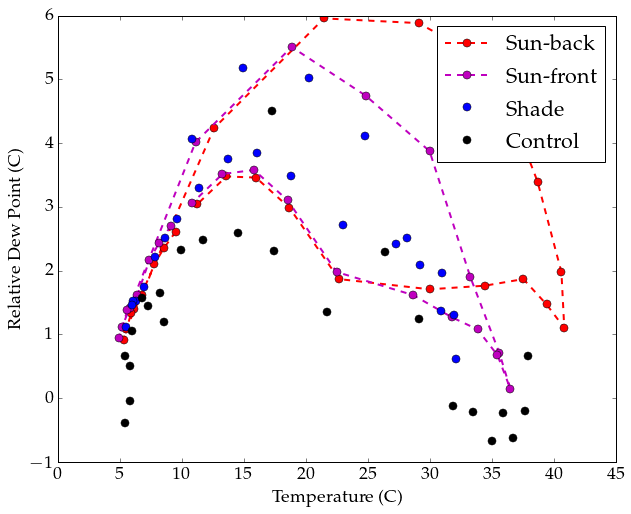

In [163]:
plt.plot(Ani_panda.TSb,Ani_panda.DSb,'--ro',markersize=8)
plt.plot(Ani_panda.TSf,Ani_panda.DSf,'--mo',markersize=8)
plt.plot(Ani_panda.TSh,Ani_panda.DSh,'bo',markersize=8)
plt.plot(Ani_panda.TC,Ani_panda.DC,'ko',markersize=8)

plt.xlabel('Temperature (C)')
plt.ylabel('Relative Dew Point (C)')

legend((['Sun-back','Sun-front','Shade','Control']),numpoints=1)

<h1> Plot Dew point vs. Humidity </h1>

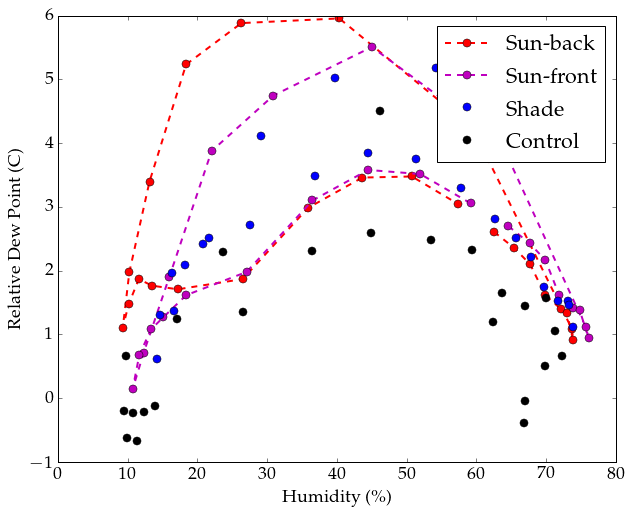

In [164]:
plt.plot(Ani_panda.HSb,Ani_panda.DSb,'--ro',markersize=8)
plt.plot(Ani_panda.HSf,Ani_panda.DSf,'--mo',markersize=8)
plt.plot(Ani_panda.HSh,Ani_panda.DSh,'bo',markersize=8)
plt.plot(Ani_panda.HC,Ani_panda.DC,'ko',markersize=8)

plt.xlabel('Humidity (\%)')
plt.ylabel('Relative Dew Point (C)')

legend((['Sun-back','Sun-front','Shade','Control']),numpoints=1)

<h1> Now that we have a data frame, we can make interactive plots </h1>

In [21]:
from bokeh.plotting import figure, output_file, show, output_notebook, ColumnDataSource,hplot
from bokeh.models import CustomJS, Rect, Circle, HoverTool, VBox, HBox, Range1d, CustomJS, Slider, DateRangeSlider

In [33]:
output_file("Ani_pandna.html",title='Subsole')

source=ColumnDataSource(Ani_panda)

tools="pan,wheel_zoom,box_zoom,box_select,poly_select,reset,save,hover,click,lasso_select" #crosshair

p1 = figure(title='',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Time (hour)",y_axis_label = "Temperature (C)",x_range=Range1d(0, 27))
p2 = figure(title='',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Time (hour)",y_axis_label = "Humidity (\%)",x_range=Range1d(0, 27))
p3 = figure(title='',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Time (hour)",y_axis_label = "Relative Dew Point (C)",x_range=Range1d(0, 27))
p4 = figure(title='Temperature vs. Humidity',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Temperature (C)",y_axis_label = "Humidity (\%)")
p5 = figure(title='Temperature vs. Dew Point',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Temperature (C)",y_axis_label = "Relative Dew Point (C)")
p6 = figure(title='Humidity vs. Dew Point',plot_width=800, plot_height=250, tools=tools,x_axis_label = "Humidity (\%)",y_axis_label = "Relative Dew Point (C)")


#p1.x_range=(Range1d(0, 30))
#setup custum hovertool display
hover1 = p1.select(dict(type=HoverTool))
hover1.tooltips = [("(Hour, Value)", ("@index, $y"))] #don't need index("index", "$index")

p1.scatter('index', 'TSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.2,alpha=1,line_color="red",line_width=1,name='p1')
p1.scatter('index', 'TSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.2,alpha=1,line_color="purple",line_width=1,name='p1')
p1.scatter('index', 'TSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.2,alpha=1,line_color="blue",line_width=1,name='p1')
p1.scatter('index', 'TC', source=source, size=6, color='black',legend='Control',fill_alpha=.2,alpha=1,line_color="black",line_width=1,name='p1')


#setup custum hovertool display
hover2 = p2.select(dict(type=HoverTool))
hover2.tooltips = [("(Hour, Value)", ("@index, $y"))] #don't need index("index", "$index")

p2.scatter('index', 'HSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.2,alpha=1,line_color="red",line_width=1,name='p1')
p2.scatter('index', 'HSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.2,alpha=1,line_color="purple",line_width=1,name='p1')
p2.scatter('index', 'HSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.2,alpha=1,line_color="blue",line_width=1,name='p1')
p2.scatter('index', 'HC', source=source, size=6, color='black',legend='Control',fill_alpha=.2,alpha=1,line_color="black",line_width=1,name='p1')

#setup custum hovertool display
hover3 = p3.select(dict(type=HoverTool))
hover3.tooltips = [("(Hour, Value)", ("@index, $y"))] #don't need index("index", "$index")

p3.scatter('index', 'DSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.3,alpha=1,line_color="red",line_width=1,name='p1')
p3.scatter('index', 'DSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.3,alpha=1,line_color="purple",line_width=1,name='p1')
p3.scatter('index', 'DSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.3,alpha=1,line_color="blue",line_width=1,name='p1')
p3.scatter('index', 'DC', source=source, size=6, color='black',legend='Control',fill_alpha=.3,alpha=1,line_color="black",line_width=1,name='p1')


#setup custum hovertool display
hover4 = p4.select(dict(type=HoverTool))
hover4.tooltips = [("Hour", "@index"), ("Temp","$x"), ("Hum","$y")] #don't need index("index", "$index")

p4.scatter('TSb', 'HSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.3,alpha=1,line_color="red",line_width=1,name='p1')
p4.scatter('TSf', 'HSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.3,alpha=1,line_color="purple",line_width=1,name='p1')
p4.scatter('TSh', 'HSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.3,alpha=1,line_color="blue",line_width=1,name='p1')
p4.scatter('TC', 'HC', source=source, size=6, color='black',legend='Control',fill_alpha=.3,alpha=1,line_color="black",line_width=1,name='p1')


#setup custum hovertool display
hover5 = p5.select(dict(type=HoverTool))
hover5.tooltips = [("Hour", "@index"), ("Temp","$x"), ("Dew","$y")] #don't need index("index", "$index")

p5.scatter('TSb', 'DSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.3,alpha=1,line_color="red",line_width=1,name='p1')
p5.scatter('TSf', 'DSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.3,alpha=1,line_color="purple",line_width=1,name='p1')
p5.scatter('TSh', 'DSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.3,alpha=1,line_color="blue",line_width=1,name='p1')
p5.scatter('TC', 'DC', source=source, size=6, color='black',legend='Control',fill_alpha=.3,alpha=1,line_color="black",line_width=1,name='p1')

#setup custum hovertool display
hover6 = p6.select(dict(type=HoverTool))
hover6.tooltips = [("Hour", "@index"), ("Hum","$x"), ("Dew","$y")] #don't need index("index", "$index")

p6.scatter('HSb', 'DSb', source=source, size=6, color='red',legend='Sun-back',fill_alpha=.3,alpha=1,line_color="red",line_width=1,name='p1')
p6.scatter('HSf', 'DSf', source=source, size=6, color='purple',legend='Sun-front',fill_alpha=.3,alpha=1,line_color="purple",line_width=1,name='p1')
p6.scatter('HSh', 'DSh', source=source, size=6, color='blue',legend='Shade',fill_alpha=.3,alpha=1,line_color="blue",line_width=1,name='p1')
p6.scatter('HC', 'DC', source=source, size=6, color='black',legend='Control',fill_alpha=.3,alpha=1,line_color="black",line_width=1,name='p1')

callback = CustomJS(args=dict(source=source), code=""" 
    var value = last.get('value') 

    var data = source.get('data'); 
    index = data['index'] 
    new_indices = [] 
    for (i = 0; i < value; i++) { 
        if (i <= value) { 
            new_indices.push(i) 
        } 
    } 
    selected = source.get('selected') 
    selected['1d'].indices = new_indices 
    source.trigger('change'); 
""") 

slider = Slider(start=0, end=23, value=23, step=1, title="index", callback=callback) 
callback.args["last"] = slider

In [34]:
#this will write an html file
layout=VBox(p1,p2,p3,HBox(slider),p4,p5,p6)
show(layout)